# Neural Style Transfer Tutorial

**Author:** DuhyeonKim + Perplexity (Claude 4)


🧷 reference :
- https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/Gatys_Image_Style_Transfer_CVPR_2016_paper.pdf
- https://github.com/leongatys/PytorchNeuralStyleTransfer/blob/master/NeuralStyleTransfer.ipynb

# Part 1. VGG-19 network

- vgg-19 load and inference
- vgg-19 hidden layer visualization

## 1.1 Pretrained Model .pth download and save

In [2]:
import os
import torch
import torchvision

model_dir = os.getcwd() + '/Models/'
os.makedirs(model_dir, exist_ok=True)
vgg_conv_path = model_dir + 'vgg19-dcbb9e9d.pth'

# vgg_conv.pth가 없으면 자동 다운로드 및 저장
if not os.path.exists(vgg_conv_path):
    print('vgg_conv.pth not found. Downloading VGG-19 weights...')
    vgg19 = torchvision.models.vgg19(weights='IMAGENET1K_V1')
    torch.save(vgg19.features.state_dict(), vgg_conv_path)          # extracting only features (cnn layers)
    print('Download complete and saved as vgg19-dcbb9e9d.pth')
else:
    print('vgg19-dcbb9e9d.pth already exists.')


vgg19-dcbb9e9d.pth already exists.


## 1.2 Model Inference

classes : https://deeplearning.cms.waikato.ac.nz/user-guide/class-maps/IMAGENET/

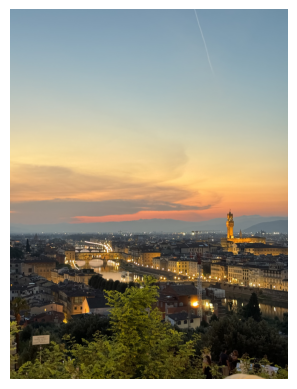

Rank  Class                          Probability
--------------------------------------------------
1     dock                               0.1752
2     palace                             0.1055
3     drilling platform                  0.0686
4     crane                              0.0678
5     triumphal arch                     0.0539


In [3]:
from PIL import Image
import torch
from torchvision import models, transforms
import matplotlib.pyplot as plt

# 1. Load ImageNet class labels from local file
with open("imagenet_classes.txt", "r") as f:
    idx_to_class = [line.strip() for line in f.readlines()]

# 2. Prepare image preprocessing pipeline (RGB 입력)
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ),
])

# 3. Load and preprocess the image
input_img = Image.open('italy.jpg').convert('RGB')
input_tensor = preprocess(input_img).unsqueeze(0)  # Add batch dimension

# 4. Load pretrained VGG19 model
vgg19 = models.vgg19(weights='IMAGENET1K_V1')
vgg19.eval()

# 5. Forward pass through VGG19
with torch.no_grad():
    output = vgg19(input_tensor)

# 6. Get the predicted class
probabilities = torch.nn.functional.softmax(output[0], dim=0)
top5_prob, top5_catid = torch.topk(probabilities, 5)

plt.imshow(input_img)
plt.axis('off')
plt.show()

print(f"{'Rank':<5} {'Class':<30} {'Probability':>10}")
print("-" * 50)
for i in range(top5_prob.size(0)):
    class_name = idx_to_class[top5_catid[i]]
    prob = top5_prob[i].item()
    print(f"{i+1:<5} {class_name:<30} {prob:>10.4f}")

# print("VGG19 output shape:", output.shape)

## 1.3 vgg-network hidden layer feature visualization

> Inorder to extract the hidden layer features, we need to access the model structure.

In [5]:
import torchvision.models as models

model = models.vgg19()
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

> Accessing model hidden layers is quite annoying

So we `redefine the model` to make it easier to access hidden layers.

Model takes an key(layer name) and returns the output of that layer.

In [4]:
state_dict = torch.load(os.path.join('Models', 'vgg19-dcbb9e9d.pth'))
print(state_dict.keys())
print(f"Number of layers in VGG-19: {len(state_dict)}")

odict_keys(['0.weight', '0.bias', '2.weight', '2.bias', '5.weight', '5.bias', '7.weight', '7.bias', '10.weight', '10.bias', '12.weight', '12.bias', '14.weight', '14.bias', '16.weight', '16.bias', '19.weight', '19.bias', '21.weight', '21.bias', '23.weight', '23.bias', '25.weight', '25.bias', '28.weight', '28.bias', '30.weight', '30.bias', '32.weight', '32.bias', '34.weight', '34.bias'])
Number of layers in VGG-19: 32


In [ ]:
# Importing the custom VGG model definition
from vgg_redefined import VGG
model = VGG()
print(model)

# VGG.load_state_dict(model, state_dict)

VGG(
  (conv1_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3_1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3_2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3_3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3_4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4_1): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4_2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4_3): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4_4): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5_1): Conv2d(512, 512,

RuntimeError: Error(s) in loading state_dict for VGG:
	Missing key(s) in state_dict: "conv1_1.weight", "conv1_1.bias", "conv1_2.weight", "conv1_2.bias", "conv2_1.weight", "conv2_1.bias", "conv2_2.weight", "conv2_2.bias", "conv3_1.weight", "conv3_1.bias", "conv3_2.weight", "conv3_2.bias", "conv3_3.weight", "conv3_3.bias", "conv3_4.weight", "conv3_4.bias", "conv4_1.weight", "conv4_1.bias", "conv4_2.weight", "conv4_2.bias", "conv4_3.weight", "conv4_3.bias", "conv4_4.weight", "conv4_4.bias", "conv5_1.weight", "conv5_1.bias", "conv5_2.weight", "conv5_2.bias", "conv5_3.weight", "conv5_3.bias", "conv5_4.weight", "conv5_4.bias". 
	Unexpected key(s) in state_dict: "0.weight", "0.bias", "2.weight", "2.bias", "5.weight", "5.bias", "7.weight", "7.bias", "10.weight", "10.bias", "12.weight", "12.bias", "14.weight", "14.bias", "16.weight", "16.bias", "19.weight", "19.bias", "21.weight", "21.bias", "23.weight", "23.bias", "25.weight", "25.bias", "28.weight", "28.bias", "30.weight", "30.bias", "32.weight", "32.bias", "34.weight", "34.bias". 

Converted state_dict keys: ['conv1_1.weight', 'conv1_1.bias', 'conv1_2.weight', 'conv1_2.bias', 'conv2_1.weight', 'conv2_1.bias', 'conv2_2.weight', 'conv2_2.bias', 'conv3_1.weight', 'conv3_1.bias', 'conv3_2.weight', 'conv3_2.bias', 'conv3_3.weight', 'conv3_3.bias', 'conv3_4.weight', 'conv3_4.bias', 'conv4_1.weight', 'conv4_1.bias', 'conv4_2.weight', 'conv4_2.bias', 'conv4_3.weight', 'conv4_3.bias', 'conv4_4.weight', 'conv4_4.bias', 'conv5_1.weight', 'conv5_1.bias', 'conv5_2.weight', 'conv5_2.bias', 'conv5_3.weight', 'conv5_3.bias', 'conv5_4.weight', 'conv5_4.bias']


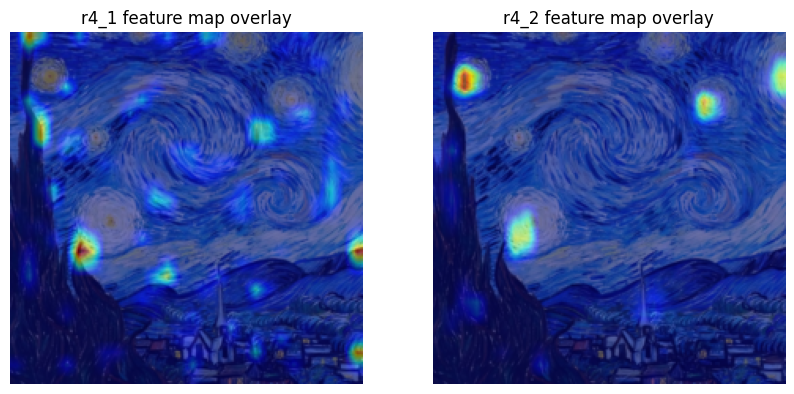

In [ ]:
from vgg_redefined import VGG

import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
import random

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

model = VGG()
state_dict = torch.load(os.path.join('Models', 'vgg19-dcbb9e9d.pth'))

# make state fit for custom VGG class
custom_vgg_keys = [
    'conv1_1', 'conv1_2',
    'conv2_1', 'conv2_2',
    'conv3_1', 'conv3_2', 'conv3_3', 'conv3_4',
    'conv4_1', 'conv4_2', 'conv4_3', 'conv4_4',
    'conv5_1', 'conv5_2', 'conv5_3', 'conv5_4'
]

vgg19_feature_indices = [0, 2, 5, 7, 10, 12, 14, 16, 19, 21, 23, 25, 28, 30, 32, 34]            # all the conv layers idx in vgg-19 pretrained

new_state_dict = {}
for idx, name in enumerate(custom_vgg_keys):
    weight_key = f"{vgg19_feature_indices[idx]}.weight"
    bias_key = f"{vgg19_feature_indices[idx]}.bias"
    
    new_state_dict[f"{name}.weight"] = state_dict[weight_key]
    new_state_dict[f"{name}.bias"] = state_dict[bias_key]

# print(f"Converted state_dict keys: {list(new_state_dict.keys())}")

# load model with new state_dict
model.load_state_dict(new_state_dict)
model.eval()

preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ),
])

img = Image.open('style_images/gogh.jpg').convert('RGB')
input_tensor = preprocess(img).unsqueeze(0)  # (1, 3, 224, 224)

# extacting features using out_keys arg in custom VGG
with torch.no_grad():
    r4_1, r4_2 = model(input_tensor, out_keys=['r41', 'r42'])

fmap1 = r4_1[0, 0].cpu().numpy()
fmap2 = r4_2[0, 2].cpu().numpy()

def unnormalize(tensor, mean, std):
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
input_vis = input_tensor.clone().squeeze(0)
input_vis = unnormalize(input_vis, mean, std)
input_vis = input_vis.permute(1, 2, 0).cpu().numpy()
input_vis = np.clip(input_vis, 0, 1)

# 2. feature map resize (224, 224로)
fmap1_resized = cv2.resize(fmap1, (input_vis.shape[1], input_vis.shape[0]))
fmap2_resized = cv2.resize(fmap2, (input_vis.shape[1], input_vis.shape[0]))

# 3. overlay plot
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(input_vis)
plt.imshow(fmap1_resized, cmap='jet', alpha=0.5)
plt.title('r4_1 feature map overlay')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(input_vis)
plt.imshow(fmap2_resized, cmap='jet', alpha=0.5)
plt.title('r4_2 feature map overlay')
plt.axis('off')

plt.show()

# Part2. NeuralStyleTransfer

There are different ways to acheive transfer.

1. Strating from `Gaussian Random Noise` tensor


2. Starting from `content image` itself

## 2.1 Starting from Gaussian noise

Using mps device


Optimizing Image:  10%|█         | 50/500 [00:10<01:34,  4.76iter/s, loss=385]    

Iteration: 50, loss: 384.722961


Optimizing Image:  20%|██        | 100/500 [00:23<01:57,  3.40iter/s, loss=235]

Iteration: 100, loss: 234.678635


Optimizing Image:  30%|███       | 150/500 [00:41<02:33,  2.27iter/s, loss=185]

Iteration: 150, loss: 185.495575


Optimizing Image:  40%|████      | 200/500 [01:07<02:48,  1.78iter/s, loss=160]

Iteration: 200, loss: 159.872253


Optimizing Image:  50%|█████     | 250/500 [01:38<02:37,  1.59iter/s, loss=144]

Iteration: 250, loss: 144.152115


Optimizing Image:  60%|██████    | 300/500 [02:12<01:36,  2.07iter/s, loss=134]

Iteration: 300, loss: 133.822998


Optimizing Image:  70%|███████   | 350/500 [02:43<01:15,  2.00iter/s, loss=127]

Iteration: 350, loss: 127.126160


Optimizing Image:  80%|████████  | 400/500 [03:05<00:39,  2.52iter/s, loss=122]

Iteration: 400, loss: 122.460876


Optimizing Image:  90%|█████████ | 450/500 [03:28<00:32,  1.52iter/s, loss=119]

Iteration: 450, loss: 119.081375


Optimizing Image: 100%|██████████| 500/500 [03:56<00:00,  1.46iter/s, loss=116]

Iteration: 500, loss: 116.406479


Optimizing Image: 520iter [04:08,  2.10iter/s, loss=116]                       


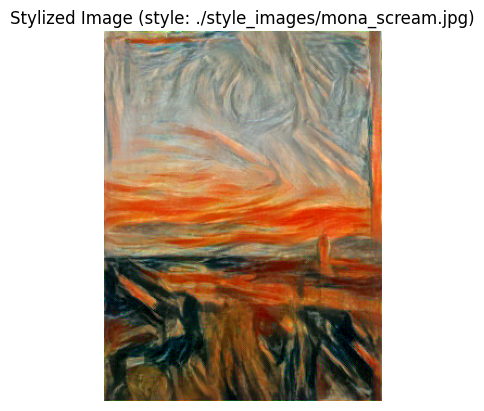

In [12]:
from vgg_redefined import VGG

import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import os
import random
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

model = VGG()
state_dict = torch.load(os.path.join('Models', 'vgg19-dcbb9e9d.pth'))

# make state fit for custom VGG class
custom_vgg_keys = [
    'conv1_1', 'conv1_2',
    'conv2_1', 'conv2_2',
    'conv3_1', 'conv3_2', 'conv3_3', 'conv3_4',
    'conv4_1', 'conv4_2', 'conv4_3', 'conv4_4',
    'conv5_1', 'conv5_2', 'conv5_3', 'conv5_4'
]

vgg19_feature_indices = [0, 2, 5, 7, 10, 12, 14, 16, 19, 21, 23, 25, 28, 30, 32, 34]            # all the conv layers idx in vgg-19 pretrained

new_state_dict = {}
for idx, name in enumerate(custom_vgg_keys):
    weight_key = f"{vgg19_feature_indices[idx]}.weight"
    bias_key = f"{vgg19_feature_indices[idx]}.bias"
    
    new_state_dict[f"{name}.weight"] = state_dict[weight_key]
    new_state_dict[f"{name}.bias"] = state_dict[bias_key]

# load model with new state_dict
model.load_state_dict(new_state_dict)
model.eval()
model.to(device)

# extacting features using out_keys arg in custom VGG
# with torch.no_grad():
#     r4_1, r4_2 = model(input_tensor, out_keys=['r41', 'r42'])

# ------------------------------- new -------------------------------
# Gram Matrix
class GramMatrix(nn.Module):
    def forward(self, input):
        b, c, h, w = input.size()
        F = input.view(b, c, h * w)
        G = torch.bmm(F, F.transpose(1, 2))
        G.div_(h * w)
        return G

class GramMSELoss(nn.Module):
    def forward(self, input, target):           # input: feature map, target: Gram matrix
        out = nn.MSELoss()(GramMatrix()(input), target)
        return out

# transform settings (imaage size, mean, std)
img_size = 256
mean = [0.48501961, 0.45795686, 0.40760392]
std = [0.229, 0.224, 0.225]

pre_p = transforms.Compose([
    transforms.Resize(img_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std),
])

postpa = transforms.Compose([
    transforms.Lambda(lambda x: x.mul(torch.tensor(std).view(-1, 1, 1)).add(torch.tensor(mean).view(-1, 1, 1)))
])

postpb = transforms.Compose([transforms.ToPILImage()])

def post_p(tensor):
    t = postpa(tensor)
    t = t.clamp(0, 1)
    img = postpb(t)
    return img

# ------------------------------- start -------------------------------
img_names = ['./style_images/mona_scream.jpg', 'italy.jpg']
imgs = [Image.open(name) for name in img_names]
imgs_torch = [pre_p(img).unsqueeze(0).to(device) for img in imgs]            # unsqueeze(0) is generally used to add a batch dimension
style_image, content_image = imgs_torch

# option1 : use the same image for style and content
opt_img = content_image.clone().requires_grad_(True)

#option2 : use a random noise image
# opt_img = torch.randn_like(content_image, device=content_image.device, requires_grad=True)          # using requires_grad=True to optimize the image

# (key point) all the array is sequential composed of [style1, style2, style3, content]
style_layers = ['r11', 'r21', 'r31', 'r41', 'r51']
content_layers = ['r42']
loss_layers = style_layers + content_layers             # loss layers' last layer [-1] is the content layer

loss_fns = [GramMSELoss()] * len(style_layers) + [nn.MSELoss()] * len(content_layers)       
loss_fns = [loss_fn.to(device) for loss_fn in loss_fns]

style_weights = [1e8 / n ** 2 for n in [64, 128, 256, 512, 512]]
content_weights = [1e1]

weights = style_weights + content_weights       

#[GramMSELoss(), GramMSELoss() ,GramMSELoss() ,GramMSELoss() ,GramMSELoss(), nn.MSELoss()]
# [style_weights, style_weights,style_weights ,style_weights ,style_weights, content_weights]

with torch.no_grad():
    style_targets = [GramMatrix().to(device)(A) for A in model(style_image, style_layers)]        # def forward(self, x, out_keys):
    content_targets = [A for A in model(content_image, content_layers)]

targets = style_targets + content_targets
# [style_target1, style_target2, style_target3, style_target4, style_target5, content_target1]

max_iter = 500
show_iter = 50
optimizer_type = "lbfgs"

pbar = tqdm(total=max_iter, desc='Optimizing Image', unit='iter')

def visualize_stylized_image(opt_img, post_p, style_image):
    out_img = post_p(opt_img.detach()[0].cpu().squeeze())
    plt.imshow(out_img)
    plt.title(f'Stylized Image (style: {style_image})')
    plt.axis('off')
    plt.show()

try:
    if optimizer_type.lower() == "lbfgs":
        optimizer = optim.LBFGS([opt_img])
        n_iter = [0]

        while n_iter[0] <= max_iter:
            def closure():
                optimizer.zero_grad()
                out = model(opt_img, loss_layers)           # [r11, r21, r31, r41, r51, r42]
                layer_losses = [weights[a] * loss_fns[a](A, targets[a]) for a, A in enumerate(out)]
                # [GramMSELoss()(r11, style_target1), GramMSELoss()(r21, style_target2), ..., content_loss(r42, content_target1)]
                loss = sum(layer_losses)
                loss.backward()
                n_iter[0] += 1
                pbar.update(1)
                if n_iter[0] % show_iter == (show_iter - 1):
                    print('Iteration: %d, loss: %f' % (n_iter[0] + 1, loss.item()))
                    # visualize_stylized_image(opt_img, post_p, img_names[0])
                pbar.set_postfix({'loss': loss.item()})
                return loss
            optimizer.step(closure)             # cause LBFGS to call closure() multiple times

    elif optimizer_type.lower() == "adam":
        optimizer = optim.Adam([opt_img], lr=0.01)
        for i in range(max_iter):
            optimizer.zero_grad()
            out = model(opt_img, loss_layers)
            layer_losses = [weights[a] * loss_fns[a](A, targets[a]) for a, A in enumerate(out)]
            loss = sum(layer_losses)
            loss.backward()
            optimizer.step()
            if i % show_iter == (show_iter - 1):
                print('Iteration: %d, loss: %f' % (i + 1, loss.item()))
                # visualize_stylized_image(opt_img, post_p, img_names[0])
            pbar.set_postfix({'loss': loss.item()})
            pbar.update(1)

    else:
        raise ValueError("optimizer_type must be 'adam' or 'lbfgs'")
    
    pbar.close()
    visualize_stylized_image(opt_img, post_p, img_names[0])

except KeyboardInterrupt:
    print("Process interrupted by user.")
    pbar.close()

In [13]:
out_img = post_p(opt_img.detach()[0].cpu().squeeze())
out_img.save("./results/italy_scream_transfer_256.png")
print("이미지가 output_style_transfer.png로 저장되었습니다.")

이미지가 output_style_transfer.png로 저장되었습니다.


## What is LBFGS?

> torch.optim.LBFGS(params, lr=1, max_iter=20, max_eval=None, tolerance_grad=1e-07, tolerance_change=1e-09, history_size=100, line_search_fn=None)[source]

 max_iter=20

In [ ]:
import torch

# 단순한 1차 함수 f(x) = (x-3)^2의 최소값을 찾는 예제
x = torch.tensor([0.0], requires_grad=True)
optimizer = torch.optim.LBFGS([x], max_iter=20, line_search_fn=None)

# closure 호출 횟수 카운터
closure_call_count = [0]

def closure():
    closure_call_count[0] += 1
    print(f"closure called: {closure_call_count[0]}")
    optimizer.zero_grad()
    loss = (x - 3) ** 2
    loss.backward()
    return loss

for step in range(5):
    closure_call_count[0] = 0
    optimizer.step(closure)
    print(f"Step {step+1}: closure was called {closure_call_count[0]} times, x = {x.item()}\n")
